# Titanic

A kaggle competition.

Author: Duarte, I. O.

Importing modules.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import math

## 1. Data

Reading datasets.

In [2]:
train_data = pd.read_csv(r'data\train.csv')
test_data = pd.read_csv(r'data\test.csv')

Datasets are concatenated into one dataset to handle data more easily.

In [3]:
train_data["Group"] = "train"
test_data["Group"] = "test"
data = pd.concat([train_data,test_data]).reset_index(drop=True)
print("Concatenated dataset (train group = "+str(len(train_data))+"; test group = "+str(len(test_data))+")")
display(data)

Concatenated dataset (train group = 891; test group = 418)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Group
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,test
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,test
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,test
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,test


## 2. Exploratory analysis

For each relevant feature the information value (IV) will be found through the informationValue() function.

In [4]:
def informationValue(feature):
    if type(data[feature][0]) != str:
        data["Bin"] = pd.qcut(data[feature], q = 10)
        survivors = data.groupby(by=["Bin"]).sum()["Survived"]
        total = data.loc[data["Group"] == 'train'].groupby(by=["Bin"]).count()["PassengerId"]
    else:
        survivors = data.groupby(by=[feature]).sum()["Survived"]
        total = data.loc[data["Group"] == 'train'].groupby(by=[feature]).count()["PassengerId"]
    IVtable = pd.DataFrame({'survivors':survivors,'non-survivors':total-survivors})
    IVtable["survDist"] = IVtable["survivors"]/IVtable["survivors"].sum()
    IVtable["nonsurvDist"] = IVtable["non-survivors"]/IVtable["non-survivors"].sum()
    IVtable["DG-DB"] = IVtable["survDist"] - IVtable["nonsurvDist"]
    IVtable["WOE"] = np.log(IVtable["survDist"]/IVtable["nonsurvDist"])
    IVtable["IV"] = IVtable["DG-DB"]*IVtable["WOE"]
    print(IVtable)
    print("IV = "+str(IVtable["IV"].sum()))

### 2.1 Sex

Men and women survivor fractions were first calculated.

In [5]:
women = data.loc[(data.Group == 'train') & (data.Sex == "female")]["Survived"]
rate_women = sum(women)/len(women)
men = data.loc[(data.Group == 'train') & (data.Sex == "male")]["Survived"]
rate_men = sum(men)/len(men)
print("% of women who survived: ",rate_women)
print("% of men who survived: ",rate_men)

% of women who survived:  0.7420382165605095
% of men who survived:  0.18890814558058924


Plot of the counts of men and women that survived or not.

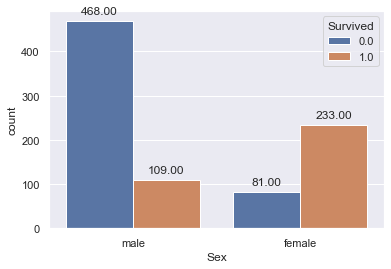

In [6]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Sex", hue="Survived", data=data.loc[data.Group == 'train'])
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

The IV for "sex" is determined.

In [7]:
informationValue("Sex")

        survivors  non-survivors  survDist  nonsurvDist     DG-DB       WOE  \
Sex                                                                           
female      233.0           81.0  0.681287     0.147541  0.533746  1.529877   
male        109.0          468.0  0.318713     0.852459 -0.533746 -0.983833   

              IV  
Sex               
female  0.816565  
male    0.525116  
IV = 1.3416814135556492


### 2.2 Age

Histogram of people in the train set by age.

Orange: survived; Blue: didn't survive


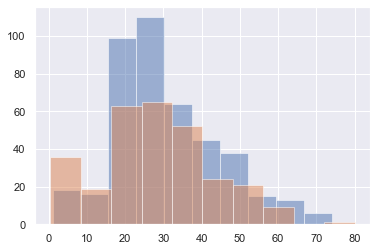

In [8]:
data.loc[data["Survived"] == 0]["Age"].hist(alpha = 0.5)
data.loc[data["Survived"] == 1]["Age"].hist(alpha = 0.5)
print("Orange: survived; Blue: didn't survive")

IV for age.

In [9]:
informationValue("Age")

               survivors  non-survivors  survDist  nonsurvDist     DG-DB  \
Bin                                                                        
(0.169, 14.0]       45.0           32.0  0.155172     0.075472  0.079701   
(14.0, 19.0]        34.0           53.0  0.117241     0.125000 -0.007759   
(19.0, 22.0]        19.0           48.0  0.065517     0.113208 -0.047690   
(22.0, 25.0]        26.0           44.0  0.089655     0.103774 -0.014118   
(25.0, 28.0]        24.0           37.0  0.082759     0.087264 -0.004506   
(28.0, 31.0]        26.0           40.0  0.089655     0.094340 -0.004684   
(31.0, 36.0]        44.0           47.0  0.151724     0.110849  0.040875   
(36.0, 42.0]        25.0           41.0  0.086207     0.096698 -0.010491   
(42.0, 50.0]        25.0           40.0  0.086207     0.094340 -0.008133   
(50.0, 80.0]        22.0           42.0  0.075862     0.099057 -0.023195   

                    WOE        IV  
Bin                                
(0.169, 14.0]  

### 2.3 Fare

Histogram of people in the train set by ticket fare.

Orange: survived; Blue: didn't survive


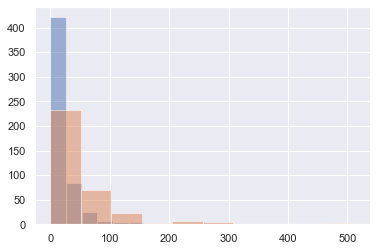

In [10]:
data.loc[data["Survived"] == 0]["Fare"].hist(alpha=0.5)
data.loc[data["Survived"] == 1]["Fare"].hist(alpha=0.5)
print("Orange: survived; Blue: didn't survive")

IV for fare.

In [11]:
informationValue("Fare")

                   survivors  non-survivors  survDist  nonsurvDist     DG-DB  \
Bin                                                                            
(-0.001, 7.568]         13.0           79.0  0.038012     0.143898 -0.105886   
(7.568, 7.854]          26.0           61.0  0.076023     0.111111 -0.035088   
(7.854, 8.05]           19.0           87.0  0.055556     0.158470 -0.102914   
(8.05, 10.5]            18.0           60.0  0.052632     0.109290 -0.056658   
(10.5, 14.454]          36.0           48.0  0.105263     0.087432  0.017831   
(14.454, 21.679]        37.0           51.0  0.108187     0.092896  0.015291   
(21.679, 26.955]        45.0           42.0  0.131579     0.076503  0.055076   
(26.955, 41.579]        37.0           60.0  0.108187     0.109290 -0.001102   
(41.579, 78.051]        45.0           40.0  0.131579     0.072860  0.058719   
(78.051, 512.329]       66.0           21.0  0.192982     0.038251  0.154731   

                        WOE        IV  

### 2.4 Ticket class

Histogram of people in the train set by ticket class.

Orange: survived; Blue: didn't survive


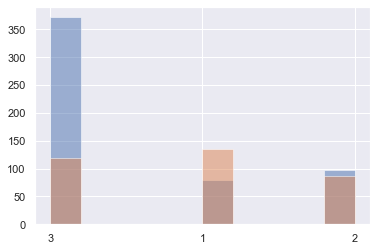

In [12]:
data["Pclass"] = pd.Series([str(x) for x in data["Pclass"]]) # The numerical categories were converted to string
data.loc[data["Survived"] == 0]["Pclass"].hist(alpha=0.5)
data.loc[data["Survived"] == 1]["Pclass"].hist(alpha=0.5)
print("Orange: survived; Blue: didn't survive")

IV for ticket class.

In [13]:
informationValue("Pclass")

        survivors  non-survivors  survDist  nonsurvDist     DG-DB       WOE  \
Pclass                                                                        
1           136.0           80.0  0.397661     0.145719  0.251941  1.003916   
2            87.0           97.0  0.254386     0.176685  0.077701  0.364485   
3           119.0          372.0  0.347953     0.677596 -0.329642 -0.666483   

              IV  
Pclass            
1       0.252928  
2       0.028321  
3       0.219701  
IV = 0.500949737583947


### 2.6 Number of siblings/spouses on board

Histogram of people in the train set by the number of siblings and/or spouses they had on board.

Orange: survived; Blue: didn't survive


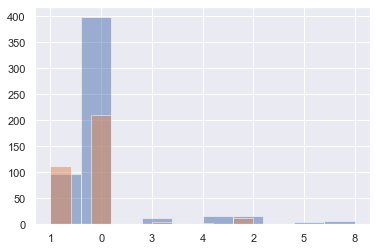

In [14]:
data["SibSp"] = pd.Series([str(x) for x in data["SibSp"]]) # This feature was also converted to string
data.loc[data["Survived"] == 0]["SibSp"].hist(alpha=0.5)
data.loc[data["Survived"] == 1]["SibSp"].hist(alpha=0.5)
print("Orange: survived; Blue: didn't survive")

IV for the number of siblings and/or spouses they had on board.

In [15]:
informationValue("SibSp")

       survivors  non-survivors  survDist  nonsurvDist     DG-DB       WOE  \
SibSp                                                                        
0          210.0          398.0  0.614035     0.724954 -0.110919 -0.166057   
1          112.0           97.0  0.327485     0.176685  0.150800  0.617076   
2           13.0           15.0  0.038012     0.027322  0.010689  0.330187   
3            4.0           12.0  0.011696     0.021858 -0.010162 -0.625325   
4            3.0           15.0  0.008772     0.027322 -0.018550 -1.136150   
5            0.0            5.0  0.000000     0.009107 -0.009107      -inf   
8            0.0            7.0  0.000000     0.012750 -0.012750      -inf   

             IV  
SibSp            
0      0.018419  
1      0.093055  
2      0.003529  
3      0.006355  
4      0.021076  
5           inf  
8           inf  
IV = inf


c:\users\igoro\appdata\local\programs\python\python39\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### 2.7 Number of parents/children on board

Histogram of people in the train set by the number of parents and/or children they had on board.

Orange: survived; Blue: didn't survive


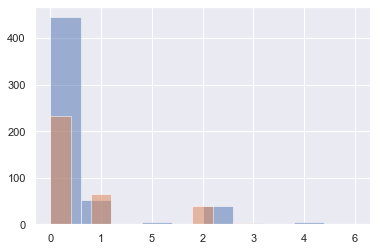

In [16]:
data["Parch"] = pd.Series([str(x) for x in data["Parch"]])
data.loc[data["Survived"] == 0]["Parch"].hist(alpha=0.5)
data.loc[data["Survived"] == 1]["Parch"].hist(alpha=0.5)
print("Orange: survived; Blue: didn't survive")

IV for the number of parents and/or children they had on board.

In [17]:
informationValue("Parch")

       survivors  non-survivors  survDist  nonsurvDist     DG-DB       WOE  \
Parch                                                                        
0          233.0          445.0  0.681287     0.810565 -0.129278 -0.173748   
1           65.0           53.0  0.190058     0.096539  0.093519  0.677383   
2           40.0           40.0  0.116959     0.072860  0.044099  0.473288   
3            3.0            2.0  0.008772     0.003643  0.005129  0.878753   
4            0.0            4.0  0.000000     0.007286 -0.007286      -inf   
5            1.0            4.0  0.002924     0.007286 -0.004362 -0.913007   
6            0.0            1.0  0.000000     0.001821 -0.001821      -inf   
9            0.0            NaN  0.000000          NaN       NaN       NaN   

             IV  
Parch            
0      0.022462  
1      0.063348  
2      0.020872  
3      0.004507  
4           inf  
5      0.003983  
6           inf  
9           NaN  
IV = inf


c:\users\igoro\appdata\local\programs\python\python39\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### 2.8 Ticket number

Histogram of people in the train set by their ticket number.

Orange: survived; Blue: didn't survive


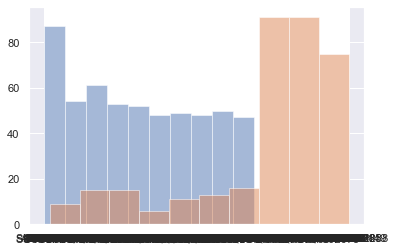

In [18]:
data.loc[data["Survived"] == 0]["Ticket"].hist(alpha=0.5)
data.loc[data["Survived"] == 1]["Ticket"].hist(alpha=0.5)
print("Orange: survived; Blue: didn't survive")

The IV was not calculated because there are too many categories in the feature.

### 2.9 Cabin number

Histogram of people in the train set by their cabin number.

Orange: survived; Blue: didn't survive


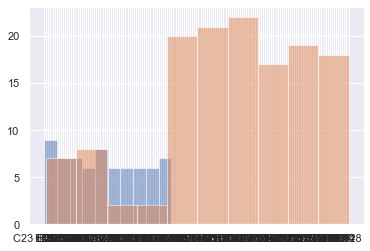

In [19]:
data.loc[data["Survived"] == 0]["Cabin"].hist(alpha=0.5)
data.loc[data["Survived"] == 1]["Cabin"].hist(alpha=0.5)
print("Orange: survived; Blue: didn't survive")

The IV was not calculated because there are too many categories in the feature.

### 2.10 Port of embarkation

Histogram of people in the train set by the city where they embarked.

Orange: survived; Blue: didn't survive


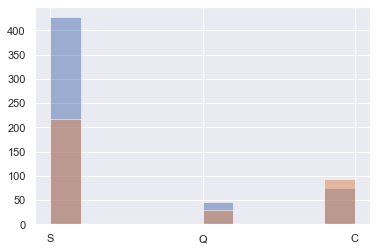

In [20]:
data.loc[data["Survived"] == 0]["Embarked"].hist(alpha=0.5)
data.loc[data["Survived"] == 1]["Embarked"].hist(alpha=0.5)
print("Orange: survived; Blue: didn't survive")

### Scatterplot of the survivor of male and female passangers considering their ages and ticket fares.

<AxesSubplot:xlabel='Fare', ylabel='Age'>

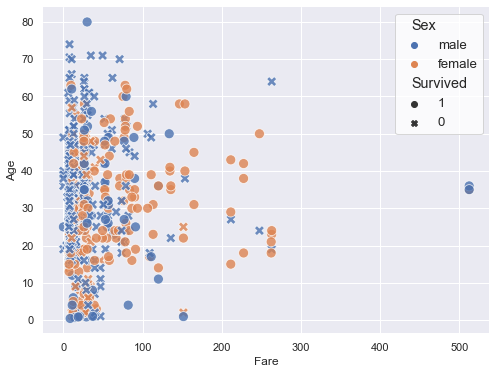

In [21]:
f, ax = plt.subplots(figsize=(8, 6))

sns.despine(f, left=True, bottom=True)
sns.set_theme(style="whitegrid",font_scale=1.2)
sns.scatterplot(x="Fare", y="Age",
                hue="Sex",
                style="Survived",
                style_order=[1,0],
                data=train_data,
                ax=ax,
                s= 100, alpha= 0.8)

## 3 Models for the binary classification

For the model constructions, the dataset is refreshed to abandon unwanted modifications.

In [22]:
data = pd.concat([train_data,test_data]).reset_index(drop=True)
survival = data.loc[data["Group"] == 'train']["Survived"]

### 1st model
Classification with a Randon Forest algorithm adjusted for (1) the ticket class, (2) the sex, (3) the number of siblings/spouses aboard and (4) the number of parents/children aboard.

In [23]:
features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(data.loc[data["Group"]=="train"][features])
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, survival)

X_test = pd.get_dummies(data.loc[data["Group"]=="test"][features])
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': data.loc[data["Group"]=="test"]["PassengerId"], 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)
print("Model 1 - Accuracy score: 77.51%")

Model 1 - Accuracy score: 77.51%


### 2nd model
Classification with a Randon Forest algorithm adjusted for (1) the ticket class, (2) the sex, (3) the age, (4) the number of siblings/spouses on board, (5) the number of parents/children on board, (6) the ticket fare and (7) the port of embarkation.

In [24]:
data["meanAge"] = data["Age"].fillna(data["Age"].mean())
data["meanFare"] = data["Fare"].fillna(data["Fare"].mean())

features = ["Pclass", "Sex", "meanAge", "SibSp", "Parch", "meanFare", "Embarked"]

X = pd.get_dummies(data.loc[data["Group"]=="train"][features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, survival)
X_test = pd.get_dummies(data.loc[data["Group"]=="test"][features])
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': data.loc[data["Group"]=="test"]["PassengerId"], 'Survived': predictions})
output.to_csv('my_submission2.csv', index=False)
print("Model 2 - Accuracy score: 77.990%")

Model 2 - Accuracy score: 77.990%


The prediction scores for the train set were calculated for Model 2 and were ploted against the number of survivors.

In [25]:
scores = model.predict_proba(X)
scores = pd.DataFrame({'Prob_scores':scores[:,1],'Survived':data.loc[data["Group"]=='train']["Survived"]})
scores = scores.sort_values(by='Prob_scores')
scores["Score_group"] = pd.qcut(scores["Prob_scores"],q=10)
scores = scores.reset_index(drop=True)

group_table = scores.groupby(by=["Score_group"]).agg(Survivor_n=("Survived","sum"),N=("Survived","count")).reset_index()
group_table["perc"] = group_table["Survivor_n"]/group_table["N"]
group_table["perc_N"] = group_table["N"]/group_table["N"].sum()

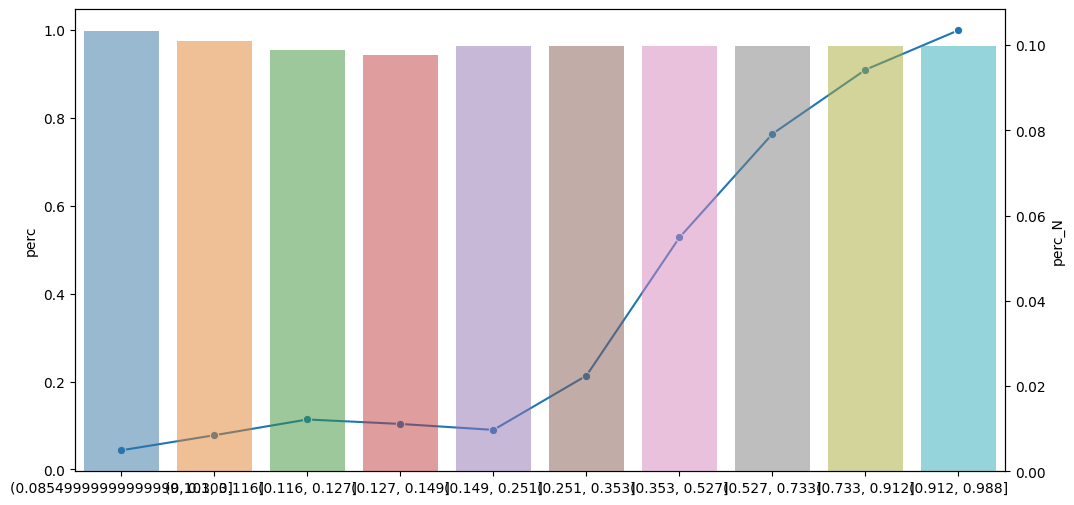

In [26]:
matplotlib.rc_file_defaults()
ax1 = sns.set_style(style=None, rc=None)
fig, ax1 = plt.subplots(figsize=(12,6))
sns.lineplot(data = group_table['perc'], marker='o', sort = False, ax=ax1)
ax2 = ax1.twinx()
sns.barplot(data = group_table, x='Score_group', y='perc_N', alpha=0.5, ax=ax2)
plt.show()